In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torchvision import datasets,transforms
from torchsummary import summary


import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

C:\Users\Lenovo\anaconda3\envs\dataml100\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Convert MNIST image files as Tensors of 4-Dimesnions (# of Images, Height, Width, Color Channel)
transformToTensor = transforms.ToTensor()

In [3]:
root_dir = './data'  # Change this path according to your setup

# Instantiate MNIST dataset
trainData = datasets.MNIST(root=root_dir, train=True,download=True, transform=transformToTensor)

In [4]:
testData = datasets.MNIST(root=root_dir,train=False,download=True, transform=transformToTensor)

In [5]:
print(trainData,testData)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
#DataLoader is used so you don't overrun your Memory with a large datset
#Creating a small batch size for images
trainLoader = DataLoader(trainData, batch_size=100,shuffle=True)
testLoader = DataLoader(testData, batch_size=100,shuffle=False)

### Single Image Example

In [7]:
#Getting Single Example from MNIST Data

for single_X_train , single_Y_train in trainLoader:
    break
    
print("As Loader Batch Size is 100 so it will give 100 images at each iteration ",single_X_train.shape)


for single_X_train , single_Y_train in trainData:
    break
    
print("As we are traversing MNIST Data Directly it will give 1 image",single_X_train.shape,"Belonging to class ", single_Y_train)

x = single_X_train
x = x.reshape(1,1,28,28)

As Loader Batch Size is 100 so it will give 100 images at each iteration  torch.Size([100, 1, 28, 28])
As we are traversing MNIST Data Directly it will give 1 image torch.Size([1, 28, 28]) Belonging to class  5


In [8]:
#Define The  Model
#Input is White and Black so 1 Channel as we are going to Give one image, #6 Filters , size of filter 3*3, stride=1, padding=valid mean no padding added
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(3,3),stride=1,padding="valid")

#Input is 6 as last layer there were 6 filters, # 16 Filters , size of filter 5*5, stride=1, padding=valid mean no padding added
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=1,padding="valid")

In [9]:

print(x.shape)

#1 layer
x = F.relu(conv1(x))
print(x.shape)
x = F.max_pool2d(x,kernel_size=(2,2),stride=2)
print(x.shape)

#2nd Layer
x = F.relu(conv2(x))
print(x.shape)
x = F.max_pool2d(x,kernel_size=(2,2),stride=2)
print(x.shape)


torch.Size([1, 1, 28, 28])
torch.Size([1, 6, 26, 26])
torch.Size([1, 6, 13, 13])
torch.Size([1, 16, 9, 9])
torch.Size([1, 16, 4, 4])


### DataSet Example

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutions Part
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(3,3),stride=1,padding="valid")
        #We are defining structure of Model so Instead of using Functional.maxpool2d we use nn.MaxPool2d
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2) 
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1,padding="valid")
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        
        # Bridge Both Parts by Flattening 
        self.Flatten = torch.nn.Flatten(start_dim=1, end_dim=-1) #As 0 index contain batch which in this case is 10
        
        # Neural Network Part
        self.fc1 = nn.Linear(in_features = 16*5*5,out_features = 120) #So the output of Convolutional Network will go into 120 Fully Connected Neurons
        self.fc2 = nn.Linear(in_features = 120,out_features = 60) #So the output of 1st FC Layer of 120 Neurons will go to 2 FC Layer of 60 Neurons
        
        #So the output of 2nd FC Layer of 60 Neurons will go to otput layer of 10 Neurons as there ARE 10 CLASSES
        self.outputLayer = nn.Linear(in_features = 60,out_features = 10) 
        
        
        
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.Flatten(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.outputLayer(x)
        
        return F.log_softmax(x)
        
#while softmax converts logits to probabilities, log softmax provides the logarithm of those probabilities 
#which can be useful for numerical stability and certain loss functions
        

In [11]:
#Create An instance and see if the model is compiled properly giving a test by input size
model = CNN()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 60]           7,260
            Linear-8                   [-1, 10]             610
Total params: 56,930
Trainable params: 56,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.22
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13464\2284576426.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [12]:
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() #As Multi-class Classification problem
optimizer = torch.optim.Adam(model.parameters(),lr=0.02)

#### Train The Model

In [13]:
import time
startTime = time.time()

epochs = 10
trainLosses = []
trainingCorrect = []

for epoch in range(epochs):
    trainingEpochCorrect = 0
    epoch_loss = 0.0
    
    for batchNumber,(XTrain,yTrain) in enumerate (trainLoader):
        batchNumber+=1
        yPred = model(XTrain)
        loss = criterion(yPred,yTrain)
        predictedValues = torch.max(yPred.data,1)[1]
        
        #How many correct we got from this batch 
        batchCorrect = (predictedValues==yTrain).sum()
        trainingEpochCorrect += batchCorrect
        
        #Accumulate Batch Loss To Compute Epoch loss
        epoch_loss +=loss.item()
        
        #Update Parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Print Results
        if batchNumber%300 == 0:
            print(f'Epoch: {epoch+1} , Batch No: {batchNumber}, Loss of This Batch: {loss.item()}')
    
    #To get Average of this epoch all losses of batches summed and divided by total batches. 
    epoch_loss = epoch_loss / len(trainLoader)
    
    #Epoch Stats
    trainLosses.append(epoch_loss)
    trainingCorrect.append(trainingEpochCorrect)
    print(f'Epoch: {epoch+1} , Avg Loss: {epoch_loss}, Total Guessed Correct in Training Data: {trainingEpochCorrect} / {len(trainData)}')



currentTime = time.time()
totalTimeConsumned = (currentTime - startTime)/60
print(f'Training took time in Minutes:  {totalTimeConsumned}')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13464\2284576426.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1 , Batch No: 300, Loss of This Batch: 0.1226305216550827
Epoch: 1 , Batch No: 600, Loss of This Batch: 0.19427216053009033
Epoch: 1 , Avg Loss: 0.20715199776925147, Total Guessed Correct in Training Data: 56128 / 60000
Epoch: 2 , Batch No: 300, Loss of This Batch: 0.13380365073680878
Epoch: 2 , Batch No: 600, Loss of This Batch: 0.23911142349243164
Epoch: 2 , Avg Loss: 0.1034075680479873, Total Guessed Correct in Training Data: 58273 / 60000
Epoch: 3 , Batch No: 300, Loss of This Batch: 0.07906707376241684
Epoch: 3 , Batch No: 600, Loss of This Batch: 0.1421235203742981
Epoch: 3 , Avg Loss: 0.09676773292128928, Total Guessed Correct in Training Data: 58411 / 60000
Epoch: 4 , Batch No: 300, Loss of This Batch: 0.02534041367471218
Epoch: 4 , Batch No: 600, Loss of This Batch: 0.01807388663291931
Epoch: 4 , Avg Loss: 0.10026498571465102, Total Guessed Correct in Training Data: 58403 / 60000
Epoch: 5 , Batch No: 300, Loss of This Batch: 0.01569918915629387
Epoch: 5 , Batch No: 600,

#### Test The Model

In [14]:
totalTestCorrect = 0
testLoss = 0
totalYPred = []

with torch.no_grad():
    
    for batch,(Xtest,yTest) in enumerate (testLoader):
        yPred = model(Xtest)
        loss = criterion(yPred,yTest)
        predictedValues = torch.max(yPred.data,1)[1]
        totalYPred = totalYPred + predictedValues.tolist()
        
        batchCorrect = (predictedValues==yTest).sum()
        totalTestCorrect += batchCorrect
        
        testLoss +=loss.item()
        
    testLoss = testLoss / len(testLoader)
    print(f'Avg Loss: {testLoss}, Total Guessed Correct in Testing Data: {totalTestCorrect} / {len(testData)}')

        
        

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13464\2284576426.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Avg Loss: 0.11145561344455927, Total Guessed Correct in Testing Data: 9759 / 10000


#### Looking At Stats

Text(0.5, 1.0, 'Training Loss at Each Epoch')

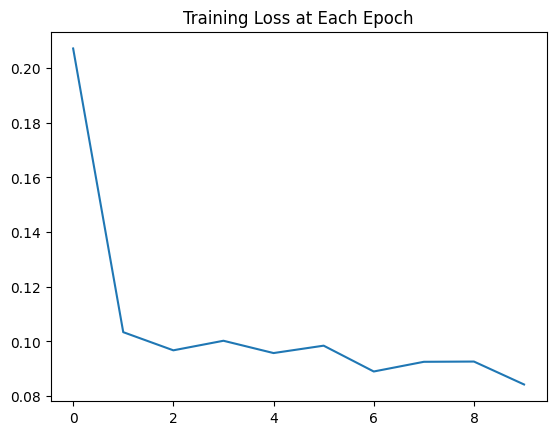

In [15]:
plt.plot(trainLosses)
plt.title("Training Loss at Each Epoch")

Text(0.5, 1.0, 'Training Accuracy at Each Epoch')

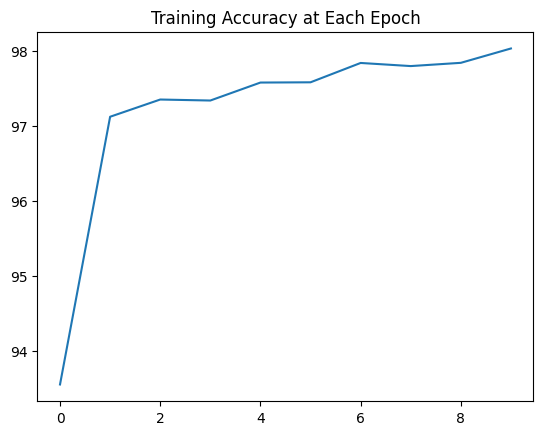

In [16]:
trainingAccuracy = [(correct / len(trainData))*100 for correct in trainingCorrect]

plt.plot(trainingAccuracy)
plt.title("Training Accuracy at Each Epoch")

In [17]:
yTest = testData.targets

confusion_matrix(yTest,totalYPred)

array([[ 972,    1,    3,    0,    0,    0,    1,    1,    1,    1],
       [   0, 1118,    2,    2,    3,    0,    2,    2,    6,    0],
       [   0,    0, 1013,   11,    1,    0,    0,    2,    5,    0],
       [   0,    0,    6,  991,    1,    8,    0,    1,    2,    1],
       [   0,    0,    1,    0,  967,    0,    0,    0,    3,   11],
       [   1,    0,    0,    6,    0,  881,    1,    0,    3,    0],
       [   6,    2,    1,    0,    4,   11,  927,    0,    7,    0],
       [   1,    1,   24,    4,    2,    1,    0,  977,    5,   13],
       [   3,    2,    5,    7,    1,   11,    0,    0,  933,   12],
       [   1,    0,    0,    3,    9,    9,    0,    3,    4,  980]],
      dtype=int64)

In [18]:
print(classification_report(yTest,totalYPred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.96      0.99      0.97       892
           6       1.00      0.97      0.98       958
           7       0.99      0.95      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



##### Testing Model For New Single Image

In [20]:
newImage = testData[1978][0]

In [21]:
newImage.shape

torch.Size([1, 28, 28])

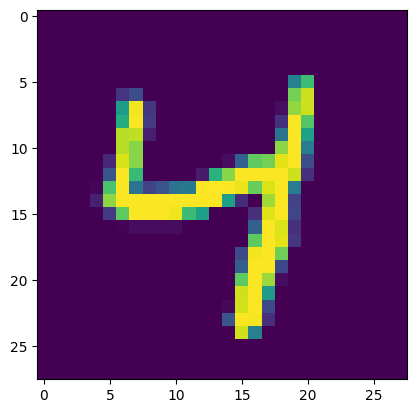

In [25]:
plt.imshow(newImage.reshape(28,28))

In [31]:
with torch.no_grad():
    yPred = model(newImage.reshape(1,1,28,28)) #Batch Size of 1, Color Channel 1, Size 28 * 28
    predictedValue = yPred.argmax()
    
    print("The image belongs to class ",predictedValue.item())

The image belongs to class  4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13464\2284576426.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
